In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [2]:
import re#Regular expressions are powerful tools for pattern matching and text manipulation. 

In [3]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

Clean Data

In [25]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
# Matches any character that is not an uppercase letter, lowercase letter, or digit.

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
#1)matches the start of the string  2) Matches a word character 3) matches the end of the string ($) or a space.
# lower all characters
sentences = sentences.lower()
print(sentences)

we are about to study the idea of computational process computational processes are abstract beings that inhabit computers as they evolve processes manipulate other abstract things called data the evolution of process is directed by pattern of rules called program people create programs to direct processes in effect we conjure the spirits of the computer with our spells


Vocabulary

In [5]:
words = sentences.split()
vocab = set(words)# a set containing unique words from the words list.
print (vocab)

{'data', 'manipulate', 'is', 'abstract', 'that', 'things', 'program', 'directed', 'conjure', 'spells', 'rules', 'other', 'computers', 'processes', 'to', 'programs', 'as', 'pattern', 'create', 'study', 'are', 'in', 'computer', 'beings', 'with', 'inhabit', 'evolution', 'about', 'of', 'evolve', 'spirits', 'the', 'people', 'idea', 'computational', 'direct', 'called', 'by', 'process', 'effect', 'they', 'we', 'our'}


In [6]:
vocab_size = len(vocab)
embed_dim = 10#dimensionality of the word embeddings.
context_size = 2# size of the context window.defines how many words to consider on each side of the target word.

Implementation 

In [7]:
#These dictionaries are used for mapping words to indices and vice versa
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

Data bags

In [8]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


Embeddings

In [9]:
# initialize word embeddings before training a neural network
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [10]:
def linear(m, theta):#calculates the dot product of the input vector or matrix m with a weight vector or matrix theta
    w = theta
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [11]:
def log_softmax(x):# transform raw scores (logits) into log probabilities. 
    e_x = np.exp(x - np.max(x))# improve numerical stability, as it prevents exponentiation of large values.
    return np.log(e_x / e_x.sum())# Divides each element by the sum of all exponential values, ensuring that the resulting array sums to 1, which is a requirement for softmax.

In [12]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]#advanced or fancy indexing to select specific elements from the logs array.
    return -out.sum()/len(out)#This line calculates the negative log likelihood loss

In [13]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)#creates an array out with the same shape as the logits array but filled with zeros.
    out[np.arange(len(logits)),target] = 1#creates a one-hot encoded matrix where each row corresponds to an example, and the column corresponding to the target class is set to 1.
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)#calculates the softmax probabilities for each class.
    #axis=-1 specifically indicates that the operation should be applied along the last axis of the array.
    # resulting values are normalized to form a valid probability distribution.
    
    return (- out + softmax) / logits.shape[0] #get the average loss per example.

Forward function

In [14]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)#is assumed to be a list or array of indices representing the context words. selected embeddings into a 2D array with one row and as many columns as needed.
    n = linear(m, theta)# linear transformation on the input.
    o = log_softmax(n)# log-softmax activation to its input.
    
    return m, n, o

Backward function

In [15]:
def backward(preds, theta, target_idxs):# backpropagation process in a neural network. 
    m, n, o = preds# tuple containing the outputs from the forward pass:
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)#gradient of the negative log-likelihood loss with respect to the input logits (n)
    dw = m.T.dot(dlog)
    
    return dw # gradient of the loss with respect to the model parameters

Optimize function

In [16]:
def optimize(theta, grad, lr=0.03):#simple gradient descent optimization step.
    theta -= grad * lr#This line updates the parameters (theta) based on the calculated gradient and the learning rate. core step for optimization
    return theta

Training 

In [17]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))
                          #low #high # shape of the output array.
    #weight matrix that connects the inputs (context embeddings) to the output layer,
#theta matrix has dimensions (2 * context_size * embed_dim, vocab_size) and is initialized with random values drawn from a uniform distribution between -1 and 1.

In [18]:
epoch_losses = {}

for epoch in range(80):
    
    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])#NumPy array containing the indices of words in the context
        preds = forward(context_idxs, theta)# is the result of the forward pass, obtaining predictions from the current model parameters (theta).

        target_idxs = np.array([word_to_ix[target]])# NumPy array containing the index of the target word.
        loss = NLLLoss(preds[-1], target_idxs)# loss calculated using the negative log-likelihood loss (NLLLoss) based on the model predictions and the true target

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)#computes the gradients of the loss with respect to the model parameters.
        theta = optimize(theta, grad, lr=0.03)#update the model parameters (theta) based on the calculated gradients and the specified learning rate
        
     
    epoch_losses[epoch] = losses

Analyze 

Plot loss/epoch

Text(0, 0.5, 'Losses')

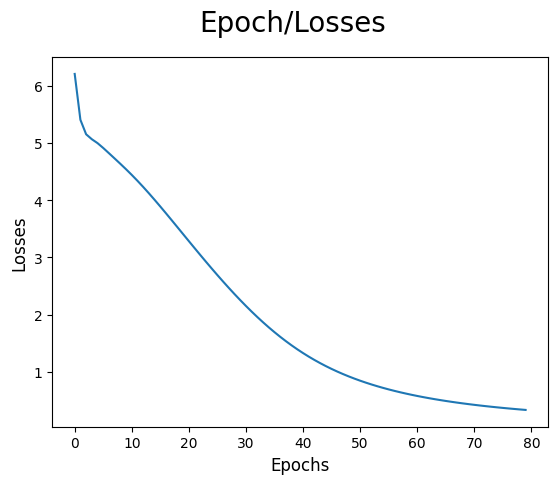

In [19]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [20]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])# input words into an array of corresponding indices using the word_to_ix dictionary.
    preds = forward(context_idxs, theta)#obtain predictions for the given context indices (context_idxs) using the trained model parameters (theta).
    word = ix_to_word[np.argmax(preds[-1])]# finds the index of the word with the highest predicted probability in the output layer
    
    return word

In [21]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

Accuracy

In [22]:
def accuracy():
    wrong = 0 #keeps track of the number of incorrect predictions.

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [23]:
accuracy()

1.0

In [24]:
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'